In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer

from plotly.offline import iplot
import plotly as py
import plotly.tools as tls

import pickle

In [2]:
df = pd.read_csv('data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1


### Data preparation and exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


In [4]:
#checking for null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


In [6]:
df['target'].value_counts()

target
1    150
2    120
Name: count, dtype: int64

In [7]:
# percentage of patience with and without heart disease
df['target'].value_counts()/df.shape[0] * 100

target
1    55.555556
2    44.444444
Name: count, dtype: float64

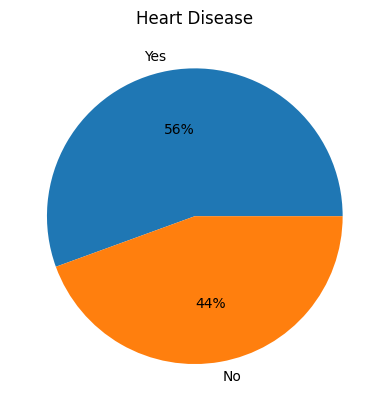

In [8]:
#creating a pie chart to display the positive and negtaive heart disease
labels = ['Yes', 'No']
values = df['target'].value_counts().values

plt.pie(values, labels = labels, autopct = '%1.0f%%')
plt.title('Heart Disease')
plt.show()

##### From the above chat, it shows that the data is relatively balanced and 
###### 56% of the people have heart disease

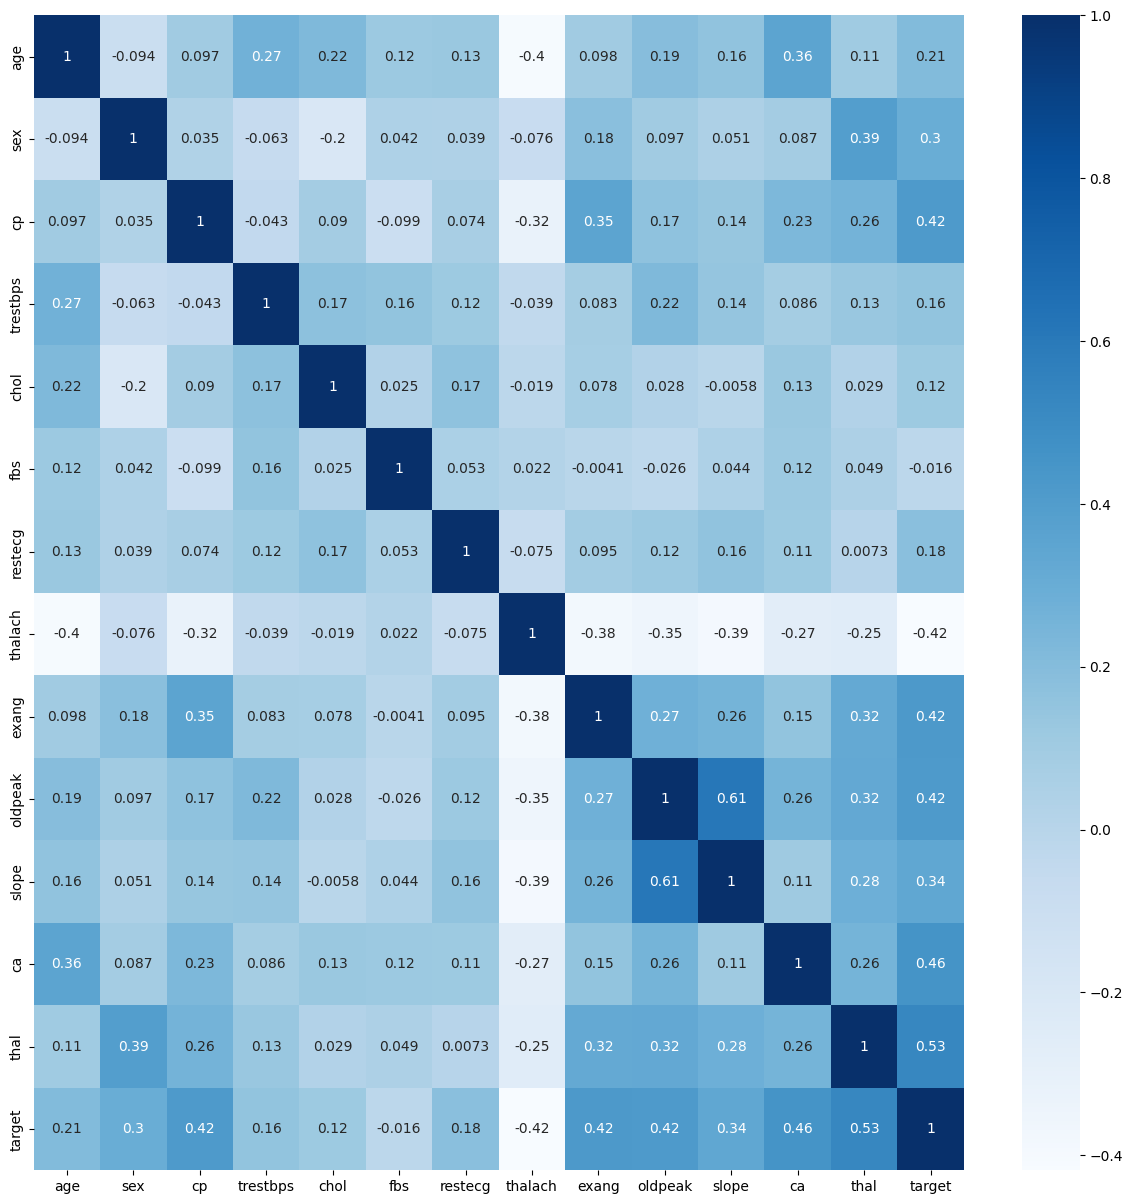

In [9]:
#correlation map

plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')
plt.show()

#### Note:

From the above correlation plot, the chest pain type (cp), exercise induced angina (exang), ST depression induced by exercise relative to rest (oldpeak), the slope of the peak exercise ST segment (slope), number of major vessels (0-3) colored by flourosopy (ca) and thalassemia (thal) are correlated with the heart disease (target) directly. We see also that there is an inverse proportion between the heart disease and maximum heart rate (thalch).

We can see also, there are a relation between the following attributes:

The number of major vessels (0-3) colored by flourosopy (ca) and the age.
ST depression induced by exercise relative to rest (oldpeak) and the slope of the peak exercise ST segment (slope).
The chest pain type (cp), exercise induced angina (exang).
maximum heart rate (thalch) and the age.

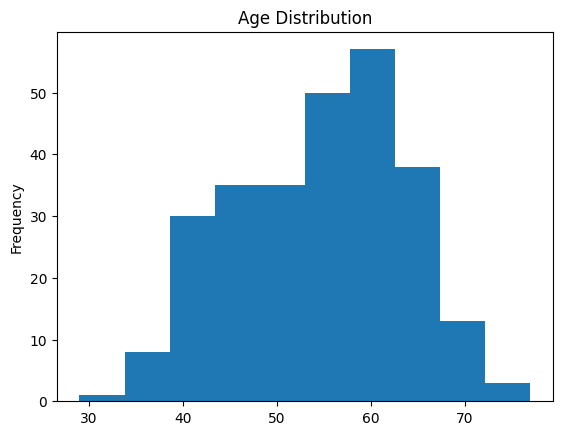

In [10]:
#age exploration
#displaying age distribution
df['age'].plot(kind = 'hist', title = 'Age Distribution')
plt.show()

In [11]:
# Get min, max and average of the age
print('Min Age: ', min(df['age']))
print('Max Age: ', max(df['age']))
print('Average Age: ',df['age'].mean())

Min Age:  29
Max Age:  77
Average Age:  54.43333333333333


C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\1771860632.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['target'] == 1]['age'], label = 'Do not have heart disease.')
C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\1771860632.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

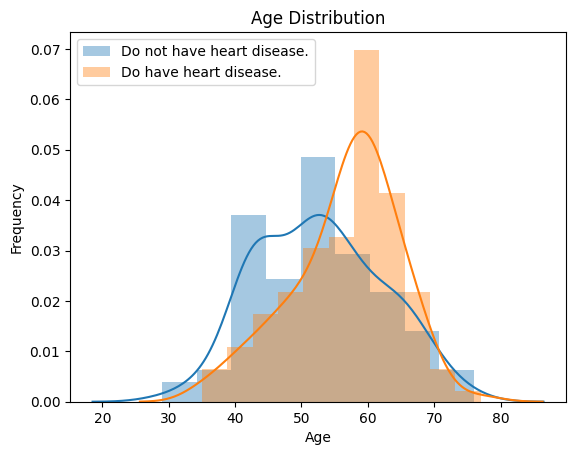

In [12]:
# Display age distribution based on heart disease
sns.distplot(df[df['target'] == 1]['age'], label = 'Do not have heart disease.')
sns.distplot(df[df['target'] == 2]['age'], label = "Do have heart disease.")

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.legend()
plt.show()

In [13]:
# Get min, max and average of the age of the people do not have heart diseas
print("Min. age of people who do not have heart disease: ", min(df[df['target'] == 1]['age']))
print('Max.  age of people who do not have heart disease: ', max(df[df['target'] == 1]['age']))
print('Average age of people who do not have heart disease: ', df[df['target'] == 1]['age'].mean())

Min. age of people who do not have heart disease:  29
Max.  age of people who do not have heart disease:  76
Average age of people who do not have heart disease:  52.70666666666666


In [14]:
# Get min, max and average of the age of the people have heart disease
print("Min. age of people who have heart disease: ", min(df[df['target'] == 2]['age']))
print('Max.  age of people who have heart disease: ', max(df[df['target'] == 2]['age']))
print('Average age of people who have heart disease: ', df[df['target'] == 2]['age'].mean())

Min. age of people who have heart disease:  35
Max.  age of people who have heart disease:  77
Average age of people who have heart disease:  56.59166666666667


#### Gender Exploration

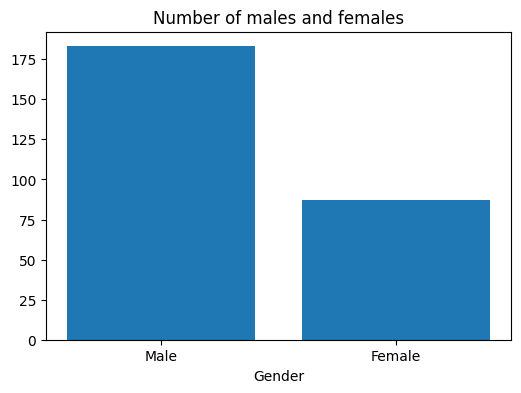

In [15]:
#Number of males and females
M = df[df['sex'] == 1].count()['target']
F = df[df['sex'] == 0].count()['target']

# creating a plot

figure, ax  = plt.subplots(figsize = (6, 4))
ax.bar(x = ['Male', 'Female'], height = [M, F])
plt.xlabel('Gender')
plt.title('Number of males and females')
plt.show()

### Chest Pain Type Exploration

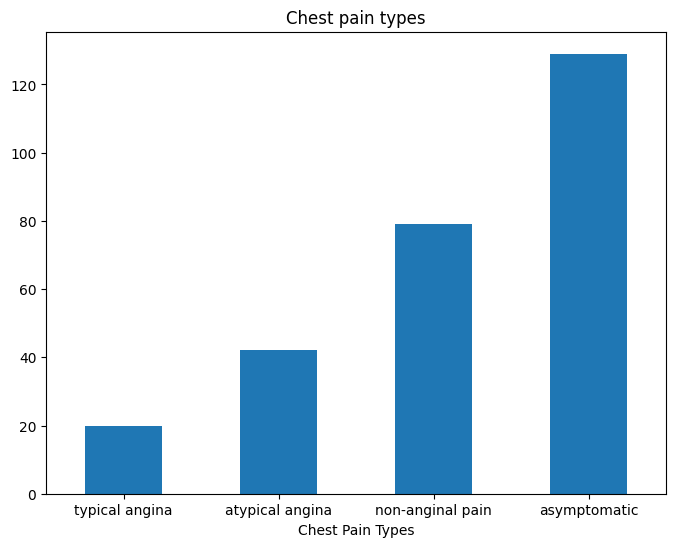

In [16]:
#display chest pain type in bar chart 
df.groupby(df['cp']).count()['target'].plot(kind = 'bar', title = 'Chest pain types', figsize = (8, 6))
plt.xlabel('Chest Pain Types')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation = 0)
plt.show()

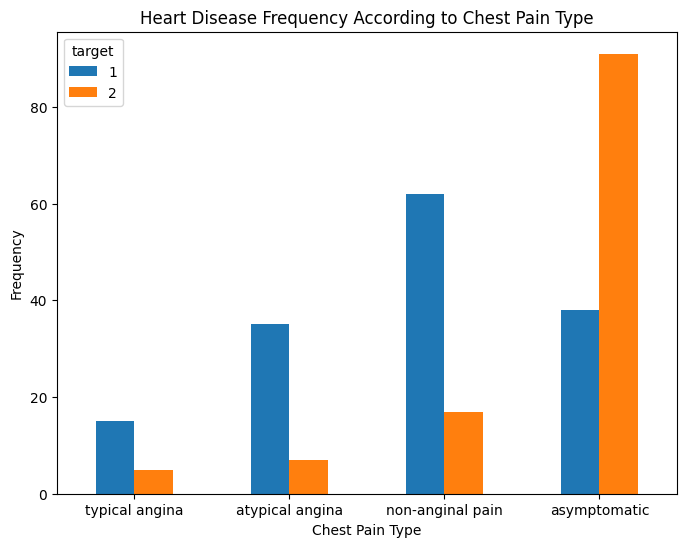

In [17]:
#display chest pain type based on on the target
pd.crosstab(df.cp, df.target).plot(kind = 'bar',figsize = (8, 6))
plt.title('Heart Disease Frequency According to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

#### Blood pressure exploration

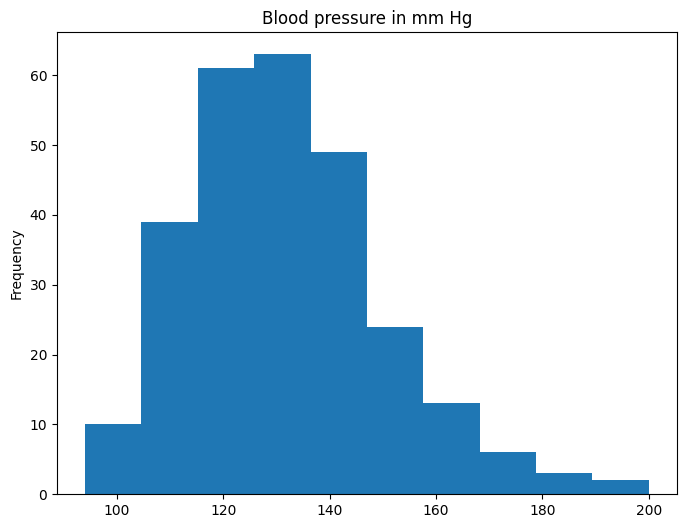

In [18]:
#Blood pressure distribution
df['trestbps'].plot(kind = 'hist', title = 'Blood pressure in mm Hg', figsize = (8, 6))
plt.show()

C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\2210145596.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[df['target'] == 1]['trestbps'], label='Do not have heart disease', ax = axis1)
C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\2210145596.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

[Text(0.5, 0, 'People who have heart disease')]

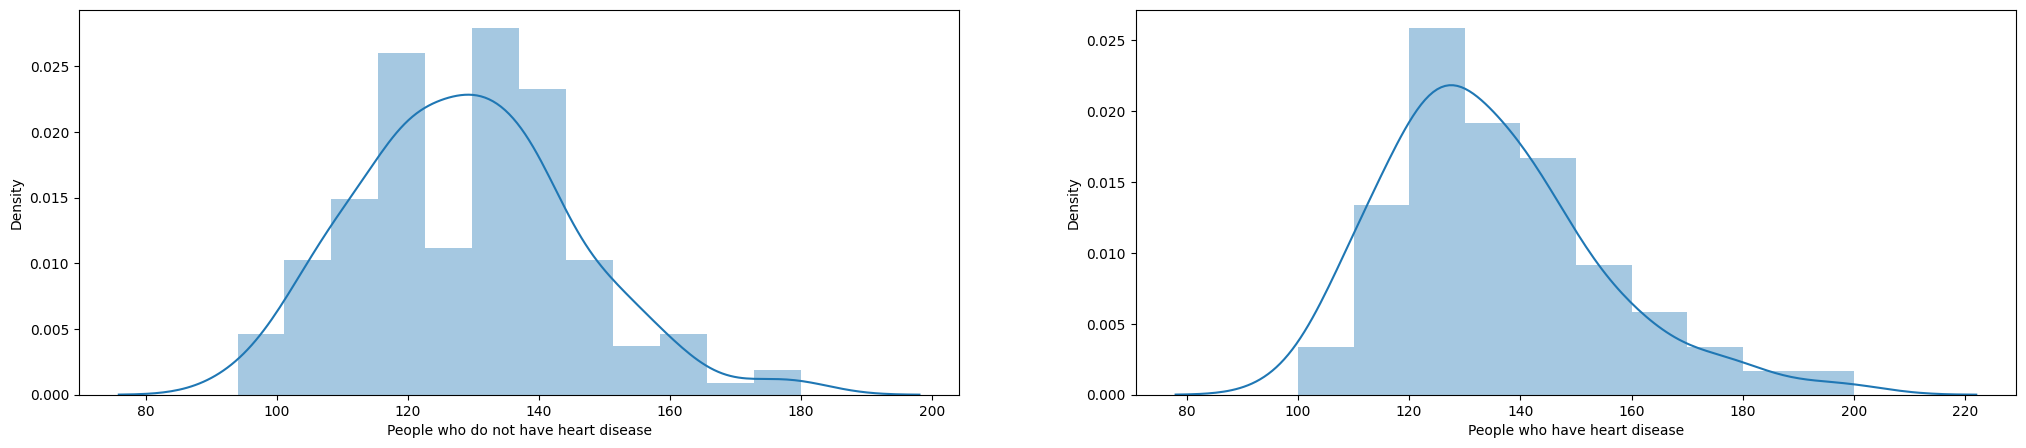

In [33]:
#Blood pressure distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (25, 5))
ax = sns.distplot(df[df['target'] == 1]['trestbps'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel = "People who do not have heart disease")
ax = sns.distplot(df[df['target'] == 2]['trestbps'], label = 'Do have heart disease', ax = axis2)
ax.set(xlabel = 'People who have heart disease')

In [26]:
#Get min, max, and average blood pressure of people who do not have heart disease
print('Min. blood pressure of people who do not have heart disease :', min(df[df['target'] == 1]['trestbps']))
print('Max. blood pressure of people who do not have heart disease :', max(df[df['target'] == 1]['trestbps']))
print('Average blood pressure of people who do not have heart disease: ', df[df['target'] == 1]['trestbps'].mean())

Min. blood pressure of people who do not have heart disease : 94
Max. blood pressure of people who do not have heart disease : 180
Average blood pressure of people who do not have heart disease:  128.86666666666667


In [27]:
# Get min, max, and average blood pressure of people who have heart disease
print('Min. blood pressure of people who have heart disease :', min(df[df['target'] == 2]['trestbps']))
print('Max. blood pressure of people who have heart disease :', max(df[df['target'] == 2]['trestbps']))
print('Average blood pressure of people who have heart disease: ', df[df['target'] == 2]['trestbps'].mean())

Min. blood pressure of people who have heart disease : 100
Max. blood pressure of people who have heart disease : 200
Average blood pressure of people who have heart disease:  134.44166666666666


### Cholestoral Exploration

<Axes: title={'center': 'Serum Cholestrol in mg/dl'}, ylabel='Frequency'>

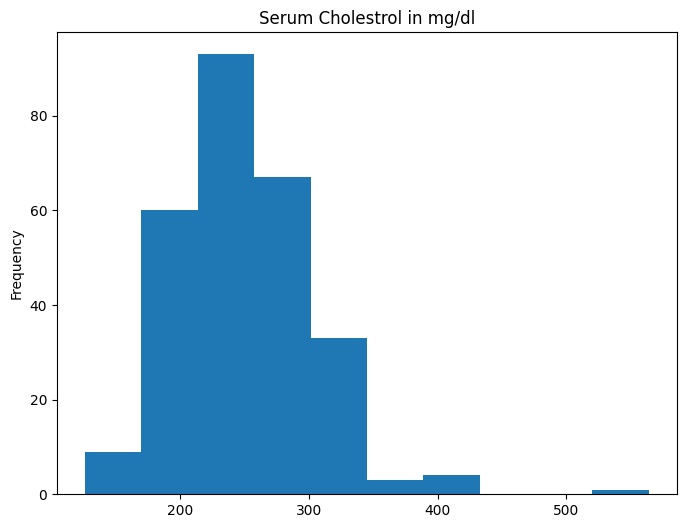

In [31]:
#cholestrol distribution
df['chol'].plot(kind = 'hist', title = 'Serum Cholestoral in mg/dl', figsize = (8, 6) )

C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\352056334.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[df['target'] == 1]['chol'], label = 'Do not have heart disease', ax = axis1)
C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\352056334.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



[Text(0.5, 0, 'People who have heart disease')]

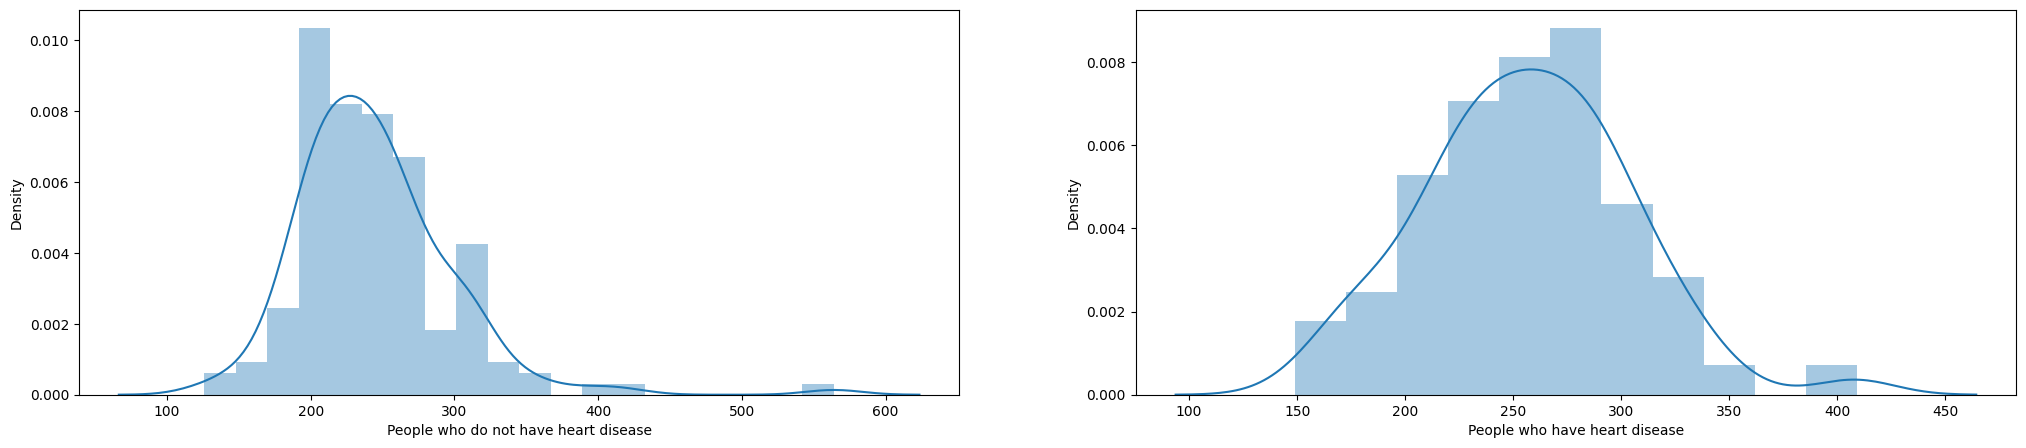

In [32]:
#cholestoral distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (25, 5))
ax = sns.distplot(df[df['target'] == 1]['chol'], label = 'Do not have heart disease', ax = axis1)
ax.set(xlabel = "People who do not have heart disease")
ax = sns.distplot(df[df['target'] == 2]['chol'], label = 'Do have heart disease', ax = axis2)
ax.set(xlabel = 'People who have heart disease')

In [35]:
#Getting the min, max, and average cholesterol of people who do not have heart disease
print('Min. cholesterol of people who do not have heart disease :', min(df[df['target'] == 1]['chol']))
print('Max. cholesterol of people who do not have heart disease :', max(df[df['target'] == 1]['chol']))
print('Average cholesterol of people who do not have heart disease :', df[df['target'] == 1]['chol'].mean())

Min. cholesterol of people who do not have heart disease : 126
Max. cholesterol of people who do not have heart disease : 564
Average cholesterol of people who do not have heart disease : 244.21333333333334


In [36]:
#Getting the min, max, and average cholesterol of people who do have heart disease
print('Min. cholesterol of people who do have heart disease :', min(df[df['target'] == 2]['chol']))
print('Max. cholesterol of people who do have heart disease :', max(df[df['target'] == 2]['chol']))
print('Average cholesterol of people who do have heart disease :', df[df['target'] == 2]['chol'].mean())

Min. cholesterol of people who do have heart disease : 149
Max. cholesterol of people who do have heart disease : 409
Average cholesterol of people who do have heart disease : 256.46666666666664


### Fasting blood sugar exploration

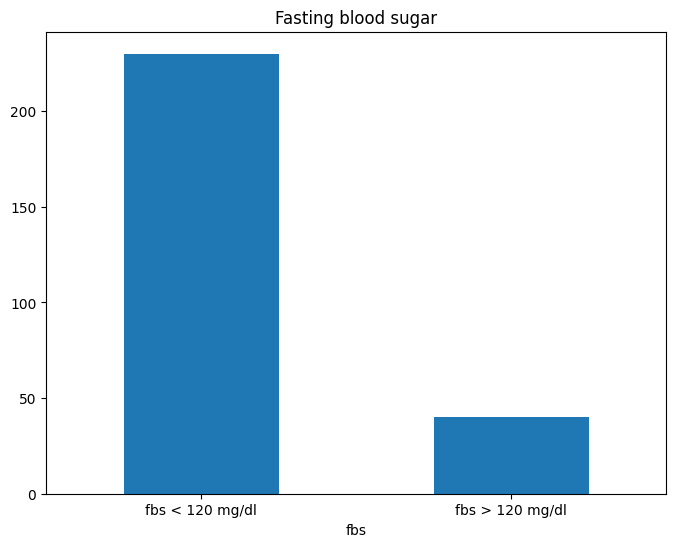

In [41]:
#fasting blood sugar distribution based on heart disease in bar chart
df.groupby(df['fbs']).count()['target'].plot(kind = 'bar', title = 'Fasting blood sugar', figsize = (8, 6))
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation = 0)
plt.show()

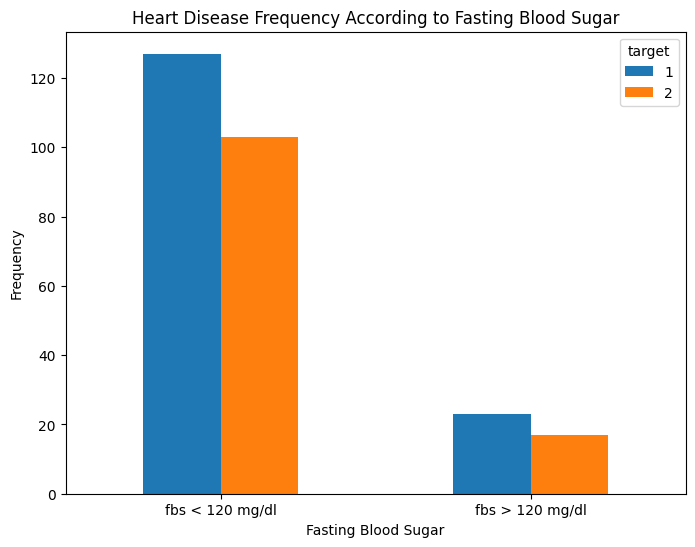

In [42]:
#fasting blood sugar based on target
pd.crosstab(df.fbs, df.target).plot(kind = 'bar', figsize = (8, 6))
plt.title('Heart Disease Frequency According to Fasting Blood Sugar')
plt.xlabel('Fasting Blood Sugar')
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

### Electrocardiographic result exploration

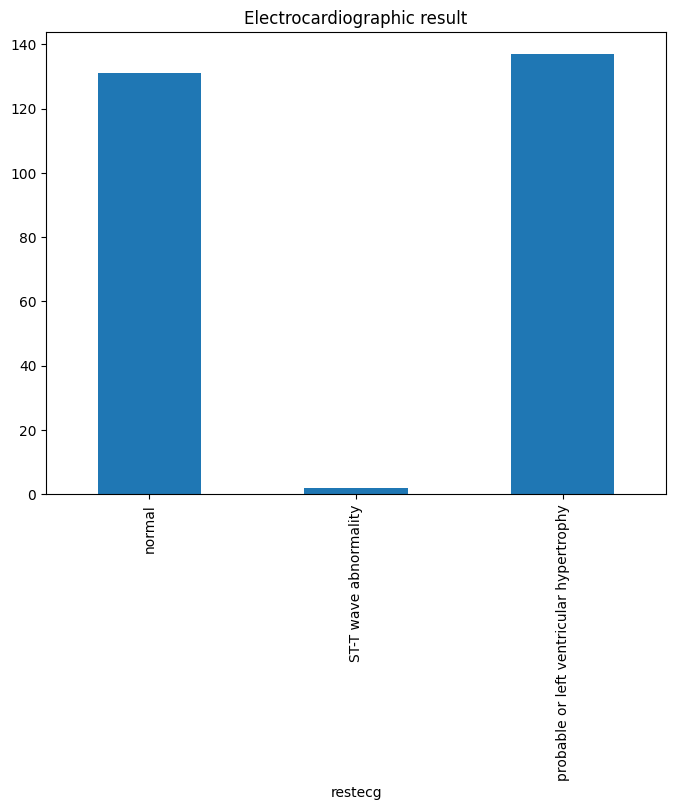

In [43]:
#electrocardiographic results in bar chart
df.groupby(df['restecg']).count()['target'].plot(kind = 'bar', title = 'Electrocardiographic result', figsize = (8, 6))
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality', 'probable or left ventricular hypertrophy'))
plt.show()

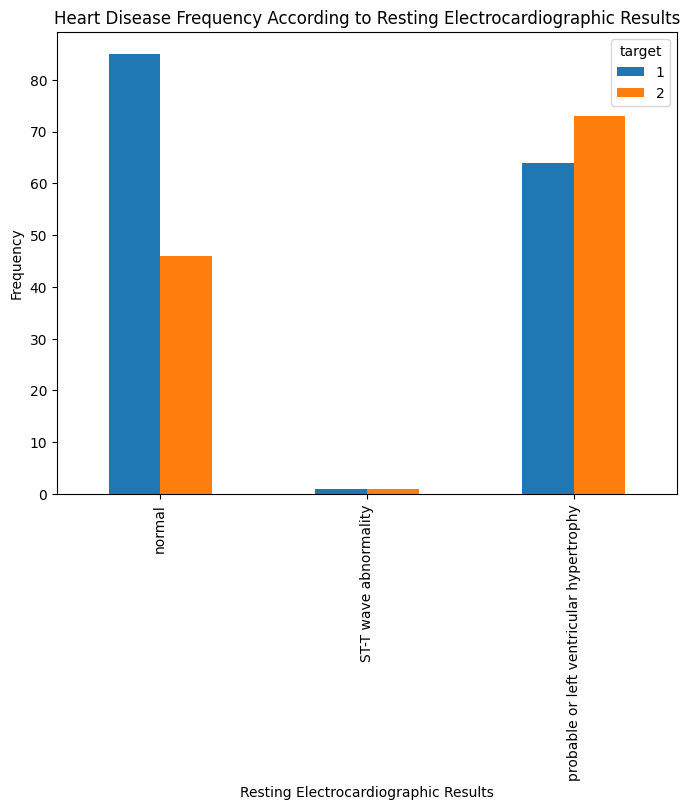

In [44]:
# Display resting electrocardiographic results based on the target
pd.crosstab(df.restecg,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Resting Electrocardiographic Results')
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality', 'probable or left ventricular hypertrophy'))
plt.xlabel('Resting Electrocardiographic Results')
plt.ylabel('Frequency')
plt.show()

#### Maximum Heart Rate Exploration

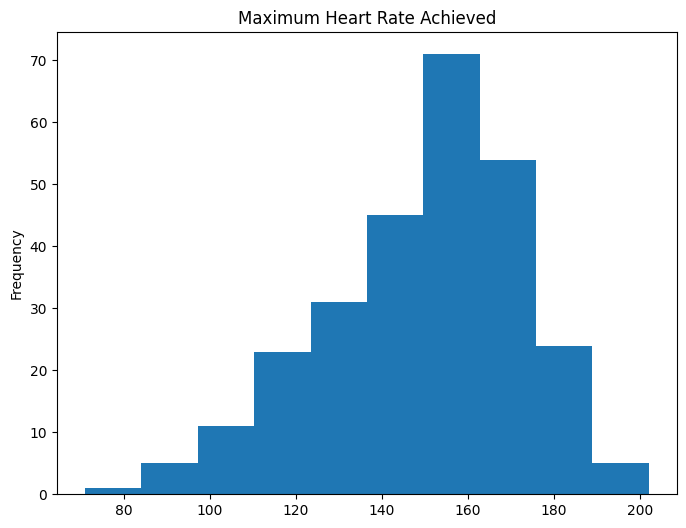

In [48]:
# maximum heart rate distribution
df['thalach'].plot(kind = 'hist', title = 'Maximum Heart Rate Achieved', figsize = (8, 6))
plt.show()

C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\1206212616.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[df['target'] == 1]['thalach'], label='Do not have heart disease', ax = axis1)
C:\Users\ANYONE\AppData\Local\Temp\ipykernel_18928\1206212616.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

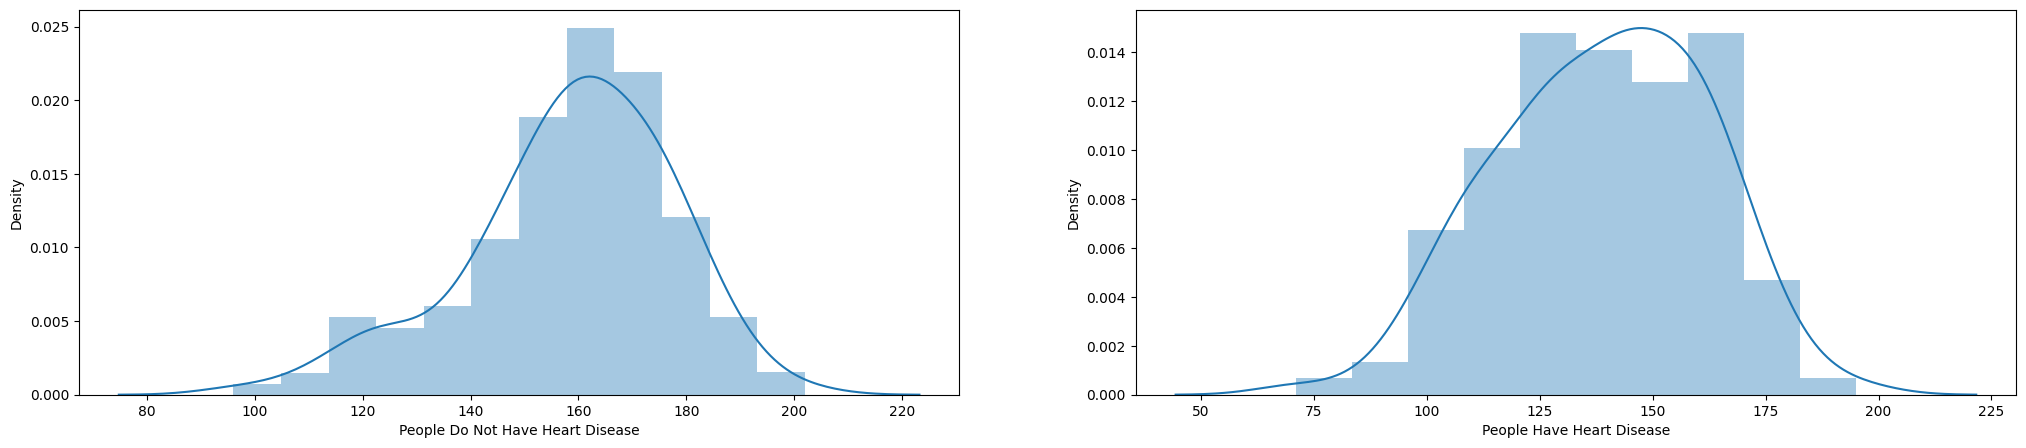

In [49]:
# maximum heart rate distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(df[df['target'] == 1]['thalach'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel = 'People Do Not Have Heart Disease')
ax = sns.distplot(df[df['target'] == 2]['thalach'], label = 'Have heart disease', ax = axis2)
ax.set(xlabel = 'People Have Heart Disease')
plt.show()

In [51]:
# Getting  min, max and average of the maximum heart rate of the people do not have heart diseas
print('Min. resting blood pressure of people who do not have heart disease: ', min(df[df['target'] == 1]['thalach']))
print('Max. resting blood pressure of people who do not have heart disease: ', max(df[df['target'] == 1]['thalach']))
print('Average resting blood pressure of people who do not have heart disease: ', df[df['target'] == 1]['thalach'].mean())

Min. resting blood pressure of people who do not have heart disease:  96
Max. resting blood pressure of people who do not have heart disease:  202
Average resting blood pressure of people who do not have heart disease:  158.33333333333334


In [52]:
# Getting min, max and average of the maximum heart rate of the people have heart diseas
print('Min. maximum heart rate  of people who have heart disease: ', min(df[df['target'] == 2]['thalach']))
print('Max. maximum heart rate people who have heart disease: ', max(df[df['target'] == 2]['thalach']))
print('Average maximum heart rate of people who have heart disease: ', df[df['target'] == 2]['thalach'].mean())

Min. maximum heart rate  of people who have heart disease:  71
Max. maximum heart rate people who have heart disease:  195
Average maximum heart rate of people who have heart disease:  138.85833333333332


### Exercise Induce Angina Exploration

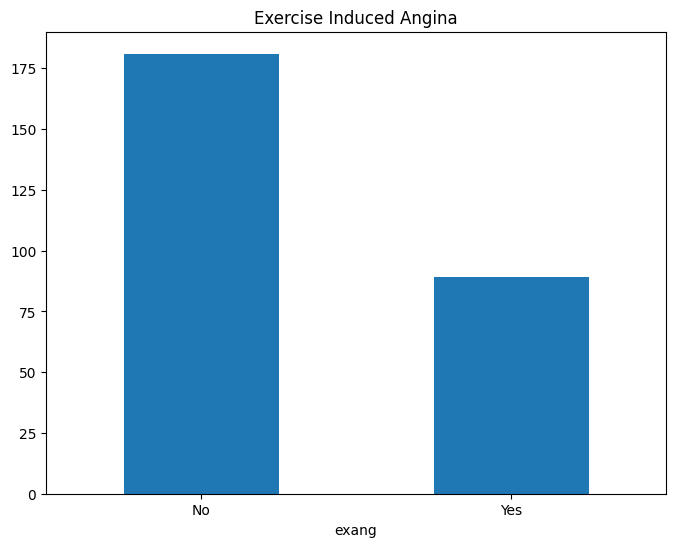

In [53]:
# exercise induced angina in bar chart
df.groupby(df['exang']).count()['target'].plot(kind = 'bar', title = 'Exercise Induced Angina',  figsize = (8, 6))
plt.xticks(np.arange(2), ('No', 'Yes'), rotation = 0)
plt.show()

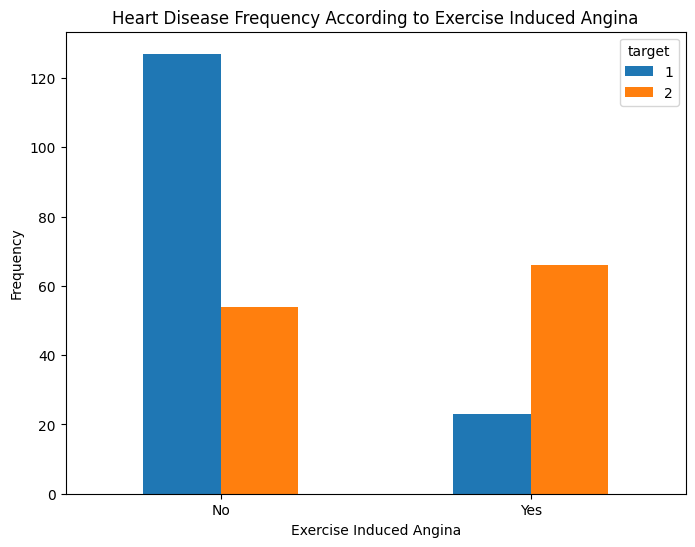

In [54]:
# exercise induced angina based on the target
pd.crosstab(df.exang,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Exercise Induced Angina')
plt.xlabel('Exercise Induced Angina')
plt.xticks(np.arange(2), ('No', 'Yes'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

#### ST depression Exploration

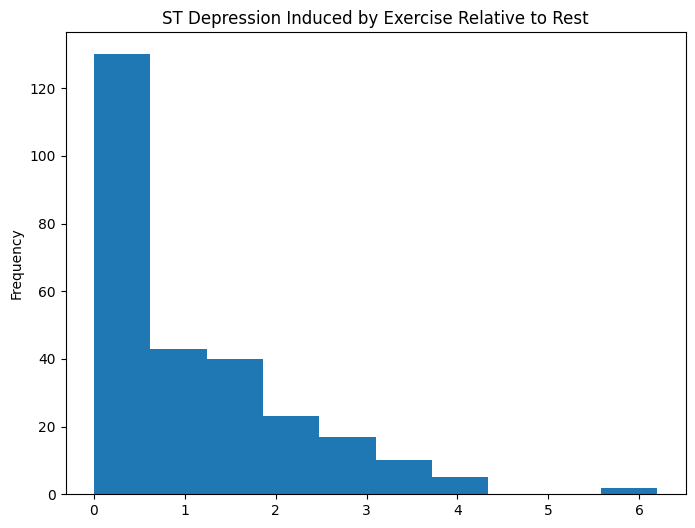

In [55]:
#ST depression induced by exercise relative to rest distribution
df['oldpeak'].plot(kind = 'hist', title = 'ST Depression Induced by Exercise Relative to Rest', figsize = (8, 6))
plt.show()

In [56]:
# Getting min, max and average of the ST depression  of the people have heart diseas
print('Min. ST depression of people who do not have heart disease: ', min(df[df['target'] == 1]['oldpeak']))
print('Max. ST depression of people who do not have heart disease: ', max(df[df['target'] == 1]['oldpeak']))
print('Average ST depression of people who do not have heart disease: ', df[df['target'] == 1]['oldpeak'].mean())

Min. ST depression of people who do not have heart disease:  0.0
Max. ST depression of people who do not have heart disease:  4.2
Average ST depression of people who do not have heart disease:  0.6226666666666667


In [57]:
# Getting min, max and average of the ST depression of the people have heart diseas
print('Min. ST depression of people who have heart disease: ', min(df[df['target'] == 2]['oldpeak']))
print('Max. ST depression of people who have heart disease: ', max(df[df['target'] == 2]['oldpeak']))
print('Average ST depression of people not have heart disease: ', df[df['target'] == 2]['oldpeak'].mean())

Min. ST depression of people who have heart disease:  0.0
Max. ST depression of people who have heart disease:  6.2
Average ST depression of people not have heart disease:  1.5841666666666667


### Slope Exploration

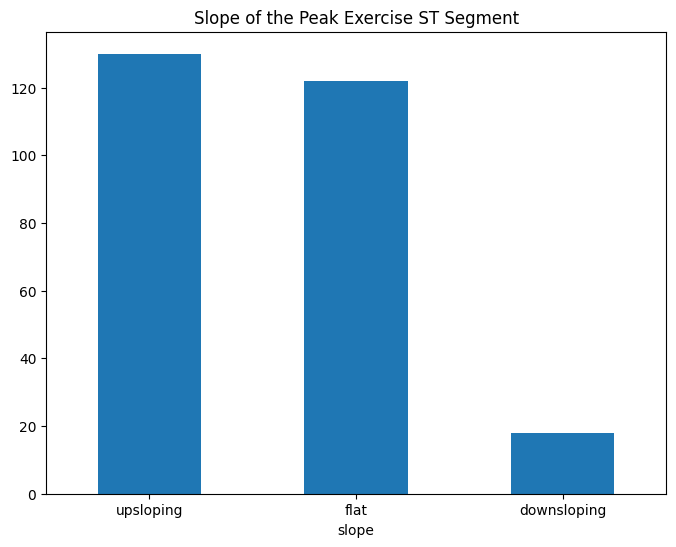

In [58]:
# slope of the peak exercise ST segment in bar chart
df.groupby(df['slope']).count()['target'].plot(kind = 'bar', title = 'Slope of the Peak Exercise ST Segment', figsize = (8, 6))
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.show()

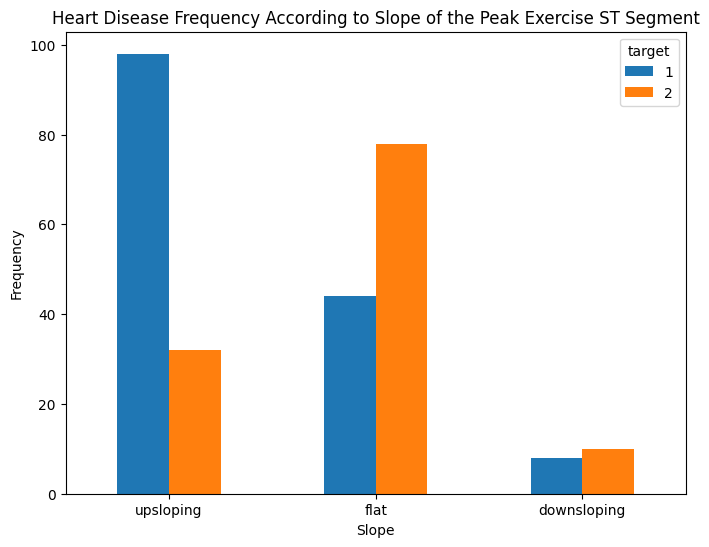

In [59]:
# slope of the peak exercise ST segment based on the target
pd.crosstab(df.slope,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Slope of the Peak Exercise ST Segment')
plt.xlabel('Slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

#### Major Vessels Exploration

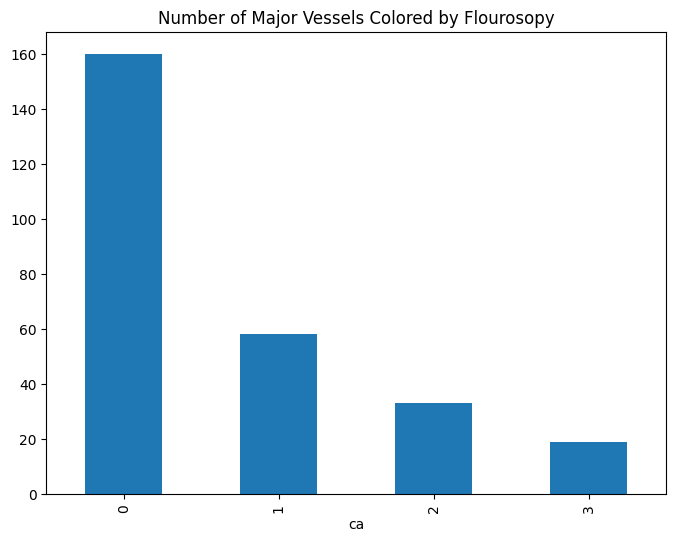

In [60]:
# number of major vessels in bar chart
df.groupby(df['ca']).count()['target'].plot(kind = 'bar', title = 'Number of Major Vessels Colored by Flourosopy', figsize = (8, 6))
plt.show()

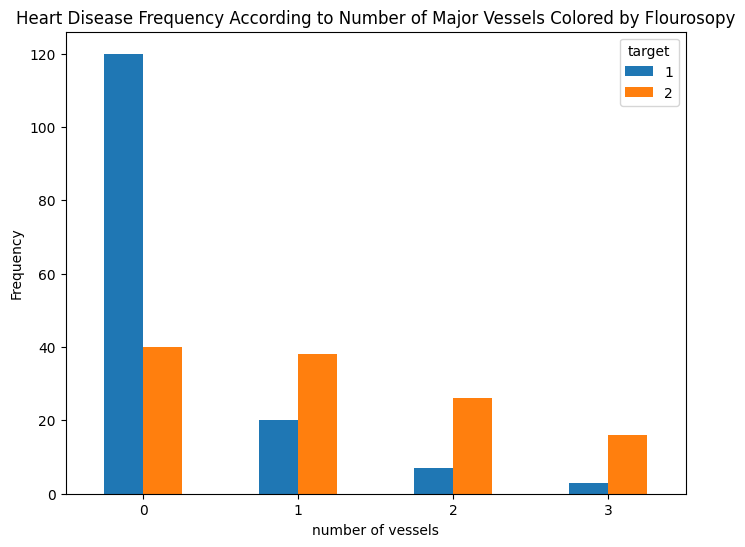

In [61]:
# number of vessels based on the target
pd.crosstab(df.ca,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Number of Major Vessels Colored by Flourosopy')
plt.xlabel('number of vessels')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

#### Thalassemia Exploration

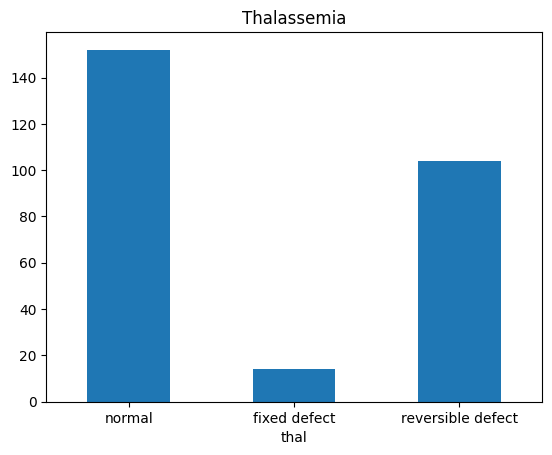

In [62]:
# thalassemia in bar chart
df.groupby(df['thal']).count()['target'].plot(kind = 'bar', title = 'Thalassemia')
plt.xticks(np.arange(3), ('normal', 'fixed defect', 'reversible defect'), rotation = 0)
plt.show()

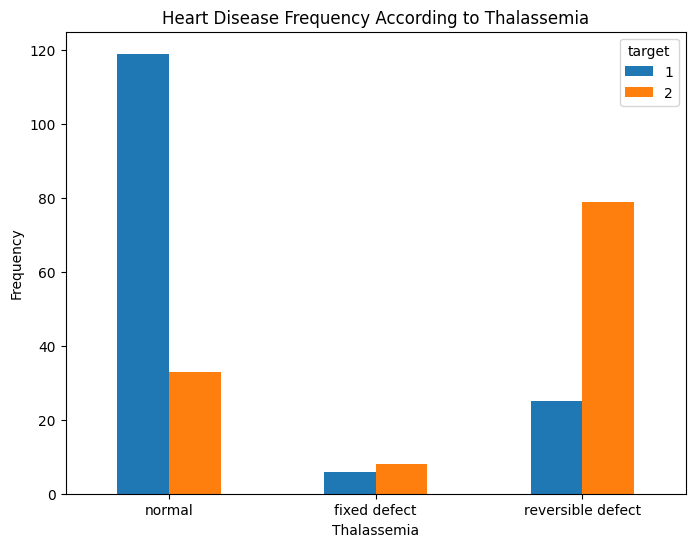

In [63]:
pd.crosstab(df.thal,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Thalassemia')
plt.xlabel('Thalassemia')
plt.xticks(np.arange(3), ('normal', 'fixed defect', 'reversible defect'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

### The correlation between heart disease, cp and exang

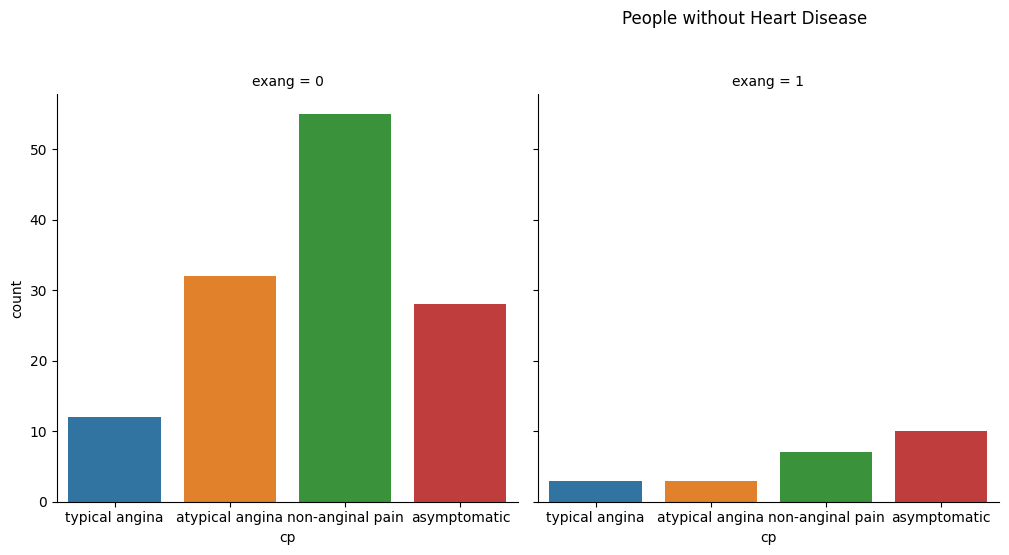

In [74]:
g = sns.catplot(x = "cp", col="exang", col_wrap=3, data = df[df['target'] == 1], kind="count")
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation=0)
g.fig.suptitle('People without Heart Disease', y=1.1)
plt.show()

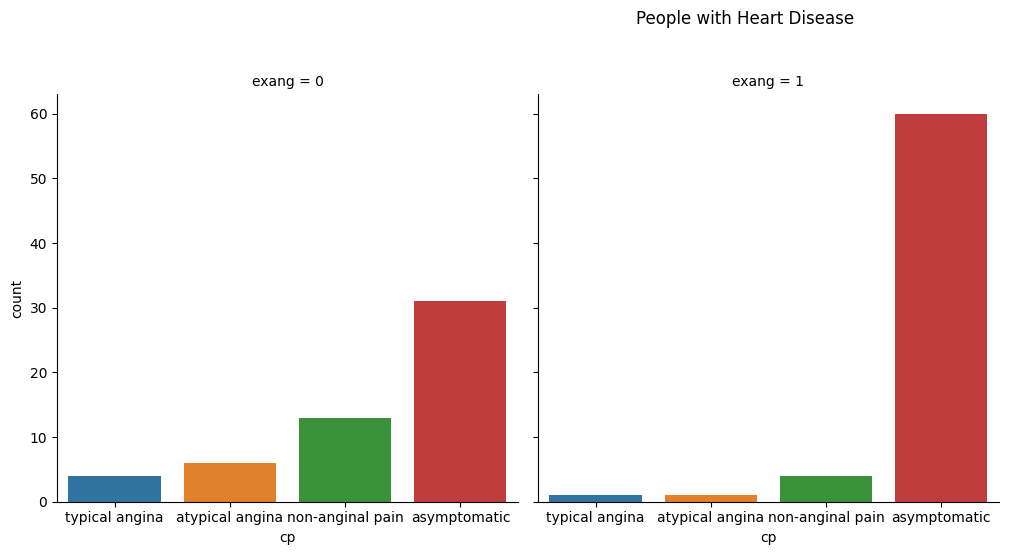

In [75]:
g = sns.catplot(x = "cp", col = "exang", col_wrap = 3, data = df[df['target'] == 2], kind = "count")
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation = 0)
g.fig.suptitle('People with Heart Disease', y = 1.1)
plt.show()

#### The correlation between oldpeak, slope and target

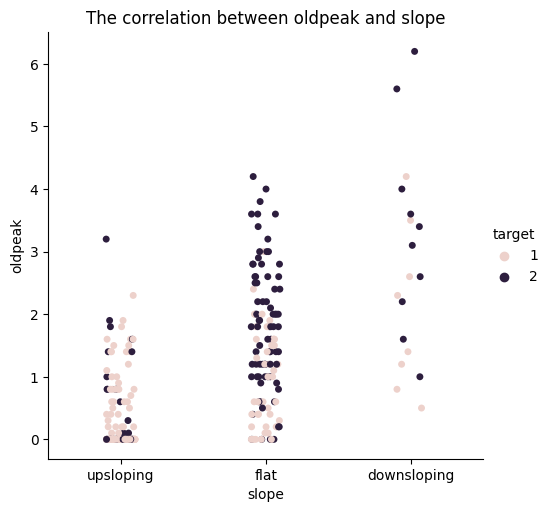

In [76]:
sns.catplot(x = "slope", y = "oldpeak", hue = "target", data = df)
plt.title('The correlation between oldpeak and slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.show()

#### The correlation between ca and age

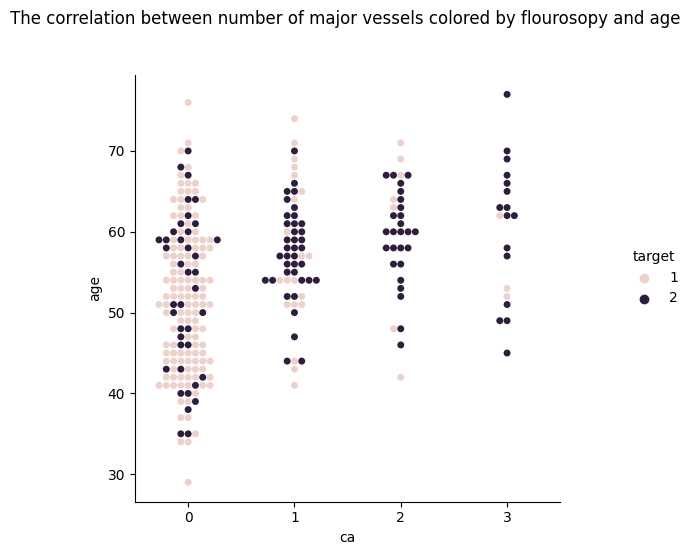

In [77]:
g = sns.catplot(x = 'ca', y = 'age', hue = 'target', data = df, kind="swarm")
g.fig.suptitle('The correlation between number of major vessels colored by flourosopy and age', y = 1.1)
plt.show()

### The correlation between age and thalach

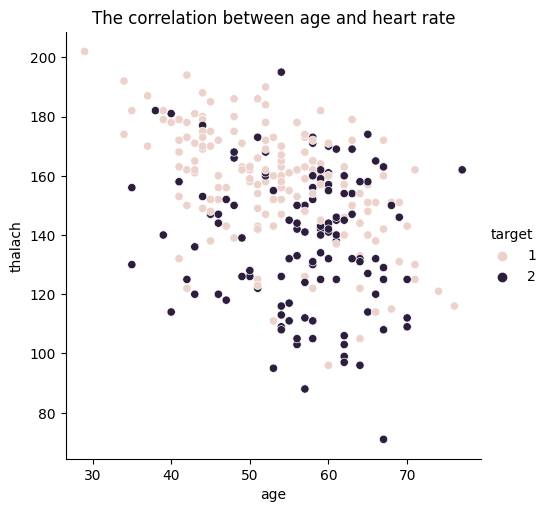

In [78]:
sns.relplot(x = 'age', y = 'thalach', data = df, hue = 'target', legend="full")
plt.title('The correlation between age and heart rate')
plt.show()

### Data Modeling

### Preparing data for machine learning 

In [83]:
#initializng data and target
target = df['target']
feature = df.drop(['target'], axis = 1)

In [84]:
#splitting the data into train and test dataset
X_train,X_test, y_train, y_test = train_test_split(feature, target, 
                                                   test_size = 0.2, 
                                                   random_state = 0
                                                  ) 

### I will be using different machine leaning algorithm to train my data and 
### choose the best based on its classification report

In [85]:
#training and evaluating the model
# Train and evaluate model
def fit_eval_model(model, train_features, y_train, test_features, y_test):
    
    """
    Function: train and evaluate a machine learning classifier.
    Args:
      model: machine learning classifier
      train_features: train data extracted features
      y_train: train data lables
      test_features: train data extracted features
      y_test: train data lables
    Return:
      results(dictionary): a dictionary of classification report
    """
    results = {}
    
    # Train the model
    model.fit(train_features, y_train)
    
    # Test the model
    train_predicted = model.predict(train_features)
    test_predicted = model.predict(test_features)
    
     # Classification report and Confusion Matrix
    results['classification_report'] = classification_report(y_test, test_predicted)
    results['confusion_matrix'] = confusion_matrix(y_test, test_predicted)
        
    return results

In [86]:
# Initialize the models
sv = SVC(random_state = 1)
rf = RandomForestClassifier(random_state = 1)
ab = AdaBoostClassifier(random_state = 1)
gb = GradientBoostingClassifier(random_state = 1)


# Fit and evaluate models
results = {}
for cls in [sv, rf, ab, gb]:
    cls_name = cls.__class__.__name__
    results[cls_name] = {}
    results[cls_name] = fit_eval_model(cls, X_train, y_train, X_test, y_test)

In [87]:
# Print classifiers results
for result in results:
    print (result)
    print()
    for i in results[result]:
        print (i, ':')
        print(results[result][i])
        print()
    print ('-----')
    print()

SVC

classification_report :
              precision    recall  f1-score   support

           1       0.71      0.90      0.79        30
           2       0.81      0.54      0.65        24

    accuracy                           0.74        54
   macro avg       0.76      0.72      0.72        54
weighted avg       0.76      0.74      0.73        54


confusion_matrix :
[[27  3]
 [11 13]]

-----

RandomForestClassifier

classification_report :
              precision    recall  f1-score   support

           1       0.76      0.73      0.75        30
           2       0.68      0.71      0.69        24

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.72      0.72      0.72        54


confusion_matrix :
[[22  8]
 [ 7 17]]

-----

AdaBoostClassifier

classification_report :
              precision    recall  f1-score   support

           1       0.75      0.80      0.77        30
           2       0.7

### From the above classification, the best classifier is GradientBoostingClassifier

Feature: age, Score: 0.05953
Feature: sex, Score: 0.01170
Feature: cp, Score: 0.28587
Feature: trestbps, Score: 0.03719
Feature: chol, Score: 0.06028
Feature: fbs, Score: 0.00082
Feature: restecg, Score: 0.00376
Feature: thalach, Score: 0.06576
Feature: exang, Score: 0.02465
Feature: oldpeak, Score: 0.13452
Feature: slope, Score: 0.04947
Feature: ca, Score: 0.17046
Feature: thal, Score: 0.09599


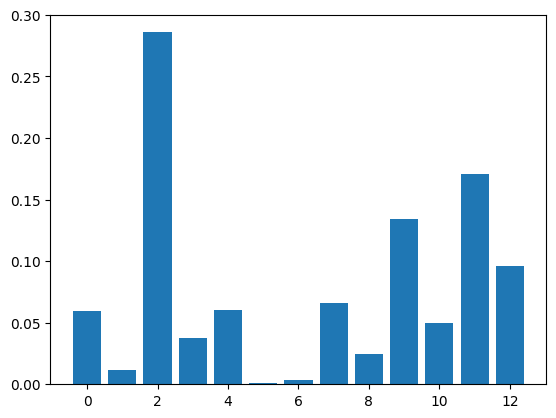

In [88]:
# getting  importance 
importance = gb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features.columns[i], v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [89]:
#saving the model
# Saving the model as serialized object pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(gb, file)